# Task VI: Quantum Representation Learning

## Setup

In [ ]:
%%capture
!pip install 'qiskit==0.46.1'
!pip install tensorflow
%pip install pylatexenc

In [ ]:
import numpy as np
# Quiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter, ParameterVector

#MNIST set libraries for the acquisition and pre-processing data.
import tensorflow as tf

#Graph libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

<ipython-input-2-58c361746f7d>:4: DeprecationWarning: qiskit.tools.jupyter is deprecated and will be removed in Qiskit 1.0.0
  from qiskit.tools.jupyter import *


## Data Loading

In [ ]:
# Loading the MNIST set divided by a train set and a test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

11490434/11490434 [==============================] - 0s 0us/step
Number of images in the training set: 60000
Number of images in the test set: 10000


### Filtering Data

In [ ]:
# Function to filter the 0 and 1 labels of the MNIST set
def filter_01(x, y):
    '''
    Input = x_label and y_label sets
    Output = x_label and y_label sets filtered
    '''
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y

In [ ]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 12665
Number of images in the test set: 2115


### Plotting Data

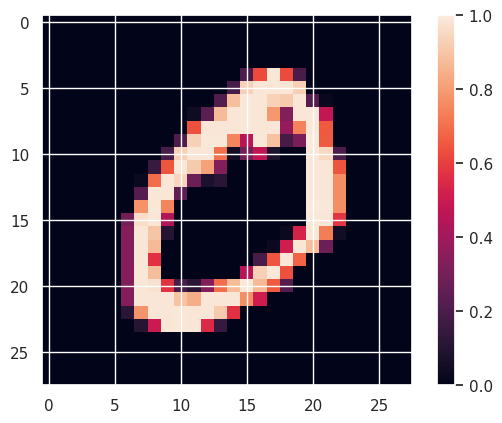

In [ ]:
# Plotting the first element of the train set
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### Resizing

In [ ]:
# Resizing the image from 28x28 to 8x8 by the nearest method
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

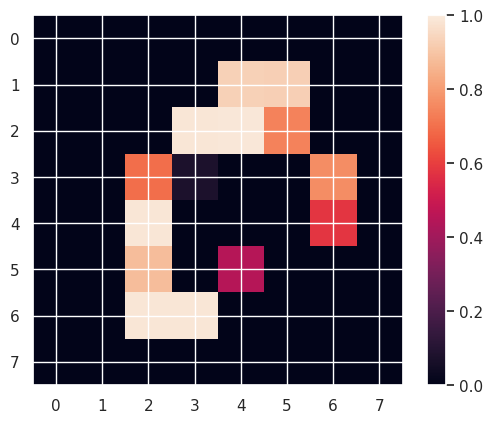

In [ ]:
# Plotting the first element of the train set after the resizing
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# Reshaping the train and test test to a 64x1 matriz
x_train = x_train_small.reshape(len(x_train_small), 64)
x_test = x_test_small.reshape(len(x_test_small), 64)
x_train.shape,x_test.shape

((12665, 64), (2115, 64))

In [ ]:
x_train_small[0]

## Create Train-Test Dataset

In [ ]:
x_train = (x_train)
x_test = (x_test)

x_train.shape, x_test.shape

((12665, 64), (2115, 64))

In [ ]:
# Deleting no valuable information for the training set
k = 0

while k < len(x_train):
    a = x_train[k].copy()
    if np.sum(a) == 0.:
        print(k,x_train[k])
        x_train = np.delete(x_train, k, axis=0)
        y_train = np.delete(y_train, k, axis=0)
        k -= 1
    k += 1

In [ ]:
# Deleting no valuable information for the test set
k = 0

while k < len(x_test):
    a = x_test[k].copy()
    if np.sum(a) == 0.:
        print(k,x_test[k])
        x_test = np.delete(x_test, k, axis=0)
        y_test = np.delete(y_test, k, axis=0)
        k -= 1
    k+=1

In [ ]:
import cmath

# Funtion to normalize the data of an array
def Normalize(row):
    '''
    Input = Array with n values
    Output = Array with normalized valued
    '''

    suma = np.sqrt(np.sum(row**2))
    if suma == 0.:
        return 0.0

    row = row/suma
    return row

# Normalize the training set data
for i in range(len(x_train)):
    x_train[i] = Normalize(x_train[i])

# Normalize the test set data
for i in range(len(x_test)):
    x_test[i] = Normalize(x_test[i])

# Showing the state sum of the training set
print("The sum of the states from the training set 0",np.sum(x_train[0]**2))

The sum of the states from the training set 0 1.0


## Create the Input Representation

In [ ]:
n = 6 # number of qubits
num_layers = 1 # number of layers

# Making a ndarray of floats based on the number of layers
params = np.random.random(10*(num_layers))

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


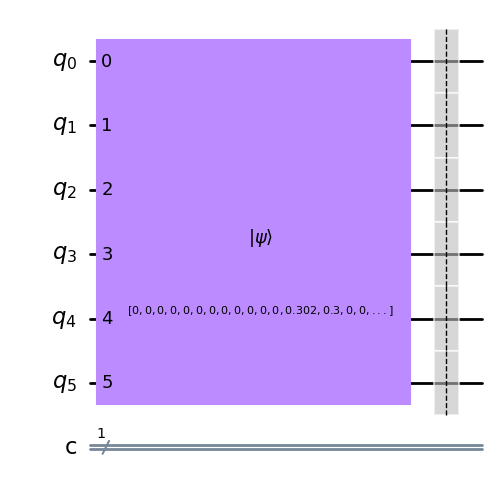

In [ ]:
# Function to create a quantum circuit based on the number of qubit and a
# vector of complex amplitudes to initialize to

def input_data(n, inputs):
    '''
    Input: Number of qubits, vector of complex amplitudes
    Output: Quantum Circuit
    '''
    circuit = QuantumCircuit(n, 1)
    circuit.initialize(inputs,range(0,n,1))
    circuit.barrier() #Draw a barrier
    return circuit

# Example of a quantum circuit with the first row of te trainig set
input_data(n,x_train[0]).draw(output="mpl")

## SWAP Tests

In [ ]:
# Function to create a SWAP test quantum circuit

def swap(n):
    '''
    Input: number of qubits, parameters to initialized the circuit
    Output: Quantum Circuit
    '''
    num_registers = int(n/2)
    qr = QuantumRegister(num_registers, 's')
    qubits = QuantumRegister(n, 'q')
    cr = ClassicalRegister(num_registers, 'r')
    circuit = QuantumCircuit(qr, qubits, cr)

    # SWAP test on pairs individually
    circuit.h(qr)
    for i in range(num_registers):
        circuit.cswap(qr[i], qubits[2*i], qubits[2*i+1])
    circuit.h(qr)

    circuit.barrier() #Create a barrier

    circuit.measure(qr, cr)

    return circuit

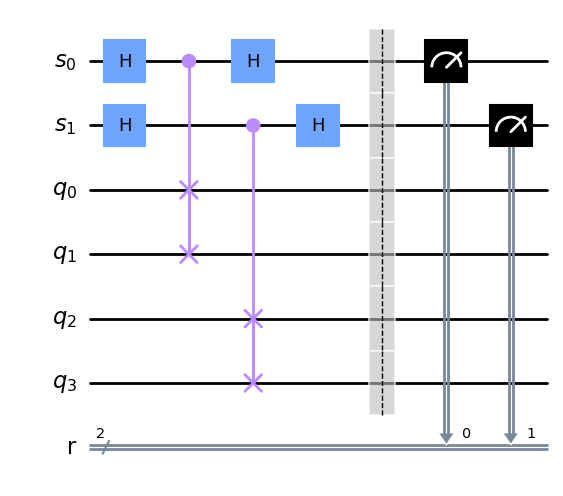

In [ ]:
swap(4).draw(output="mpl")

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


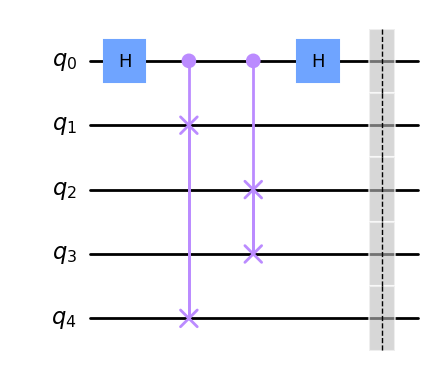

In [ ]:
def swap_test(n):
    qubits_values = 2 * +1
    qc = QuantumCircuit(qubits_values) #
    qc.h(0)
    for i in range(n):
        qc.cswap(0, i+1, 2*n-i)
    qc.h(0)
    qc.barrier()
    return qc

swap_test(2).draw(output="mpl")

## Combine the Circuit

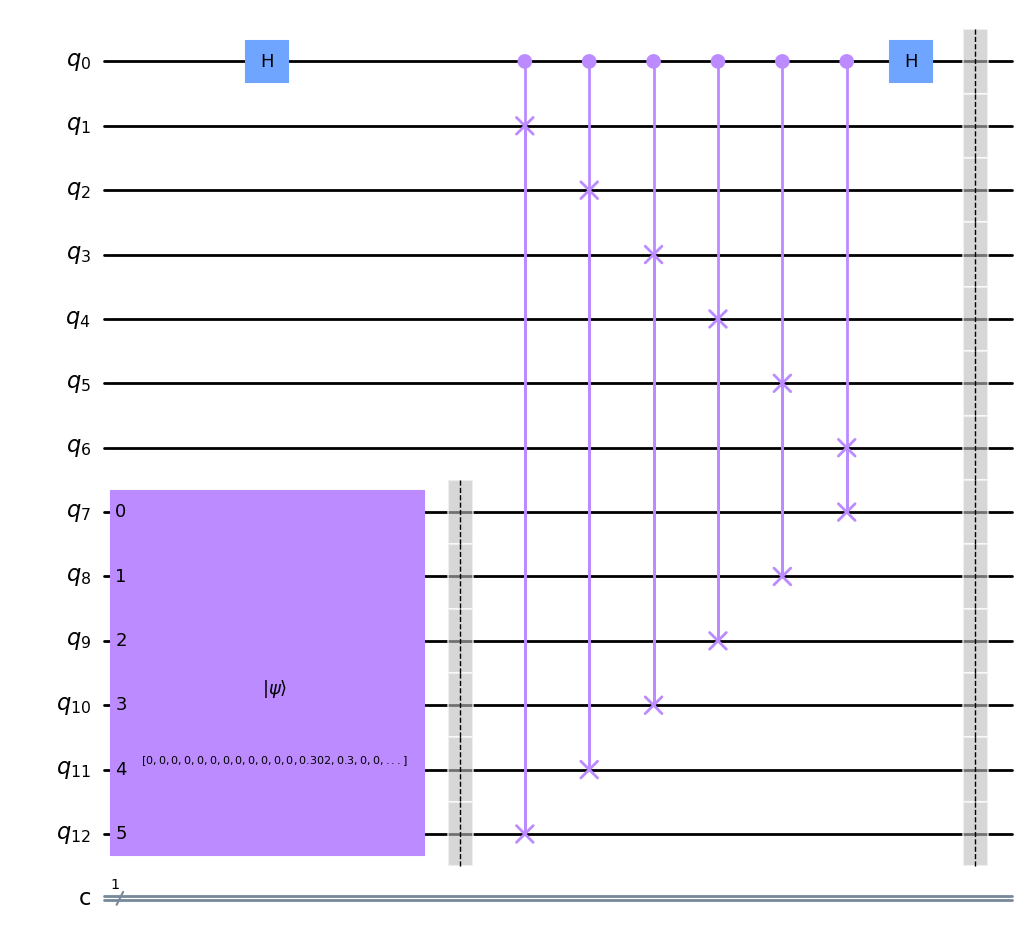

In [ ]:
size_reduce = 4 # Number of qubits we want to reduce
circuit_init = input_data(n,x_train[0])
circuit_swap_test = swap_test(size_reduce)

# Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
circuit_full = QuantumCircuit(n+size_reduce+1, 1)

# Combine the initial circuit, the quantum variatinal circuit and the swap test
circuit_full = circuit_full.compose(circuit_init, [i for i in range(size_reduce+1, n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test, [i for i in range(2 * size_reduce+1)])
circuit_full.draw(output="mpl")